# iQuHack 2026 - Quantum Entanglement Distillation Game

In this game, you design quantum circuits to distill noisy Bell pairs and claim edges in a network.

**Game Flow**: Register -> Select Starting Node -> Design Circuits -> Claim Edges -> Score Points

In [1]:
cd IonQ2026


/content/IonQ2026


In [2]:
pip install -r requirements.txt


In [3]:
from client import GameClient
from visualization import GraphTool
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import json

from pathlib import Path

## Session Management

Save/load your session to avoid re-registering.

In [4]:
SESSION_FILE = Path("session.json")

def save_session(client):
    if client.api_token:
        with open(SESSION_FILE, "w") as f:
            json.dump({"api_token": client.api_token, "player_id": client.player_id, "name": client.name}, f)
        print(f"Session saved.")

def load_session():
    if not SESSION_FILE.exists():
        return None
    with open(SESSION_FILE) as f:
        data = json.load(f)
    client = GameClient(api_token=data.get("api_token"))
    client.player_id = data.get("player_id")
    client.name = data.get("name")
    status = client.get_status()
    if status:
        print(f"Resumed: {client.player_id} | Score: {status.get('score', 0)} | Budget: {status.get('budget', 0)}")
        return client
    return None

In [5]:
# Try to resume existing session
client = load_session()

if not client:
    print("No saved session. Register below.")

Resumed: asing235 | Score: 0 | Budget: 76


## Step 1: Register

Skip this if you resumed a session above.

In [6]:
if client and client.api_token:
    print(f"Already registered as {client.player_id}")
else:
    client = GameClient()

    # CHANGE THESE to your unique values
    PLAYER_ID = "asing235"
    PLAYER_NAME = "archana"

    result = client.register(PLAYER_ID, PLAYER_NAME, location=input("remote or in_person: ").strip())

    if result.get("ok"):
        print(f"Registered! Token: {client.api_token[:20]}...")
        candidates = result["data"].get("starting_candidates", [])
        print(f"\nStarting candidates ({len(candidates)}):")
        for c in candidates:
            print(f"  - {c['node_id']}: {c['utility_qubits']} qubits, +{c['bonus_bell_pairs']} bonus")
        save_session(client)
    else:
        print(f"Failed: {result.get('error', {}).get('message')}")

Already registered as asing235


## Step 2: Select Starting Node

In [7]:
status = client.get_status()
client.print_status()

if status.get('starting_node'):
    print(f"Starting node: {status['starting_node']}")
    print(f"Budget: {status['budget']} | Score: {status['score']}")
else:
    print("Select a starting node from the candidates shown above.")
    # Uncomment and modify:
    result = client.select_starting_node("Santa Barbara, CA")
    print(result)

Player: asing235 (archana)
Score: 0 | Budget: 76 bell pairs
Active: Yes
Starting node: Santa Barbara, CA
Owned: 1 nodes, 0 edges
Claimable edges: 4
  - ['Bakersfield, CA', 'Santa Barbara, CA']: threshold=0.90, difficulty=1
  - ['Los Angeles, CA', 'Santa Barbara, CA']: threshold=0.90, difficulty=1
  - ['Pasadena, CA', 'Santa Barbara, CA']: threshold=0.90, difficulty=1
  ... and 1 more
Starting node: Santa Barbara, CA
Budget: 76 | Score: 0


## Step 3: Explore the Network

In [8]:
client.print_status()

Player: asing235 (archana)
Score: 0 | Budget: 76 bell pairs
Active: Yes
Starting node: Santa Barbara, CA
Owned: 1 nodes, 0 edges
Claimable edges: 4
  - ['Bakersfield, CA', 'Santa Barbara, CA']: threshold=0.90, difficulty=1
  - ['Los Angeles, CA', 'Santa Barbara, CA']: threshold=0.90, difficulty=1
  - ['Pasadena, CA', 'Santa Barbara, CA']: threshold=0.90, difficulty=1
  ... and 1 more


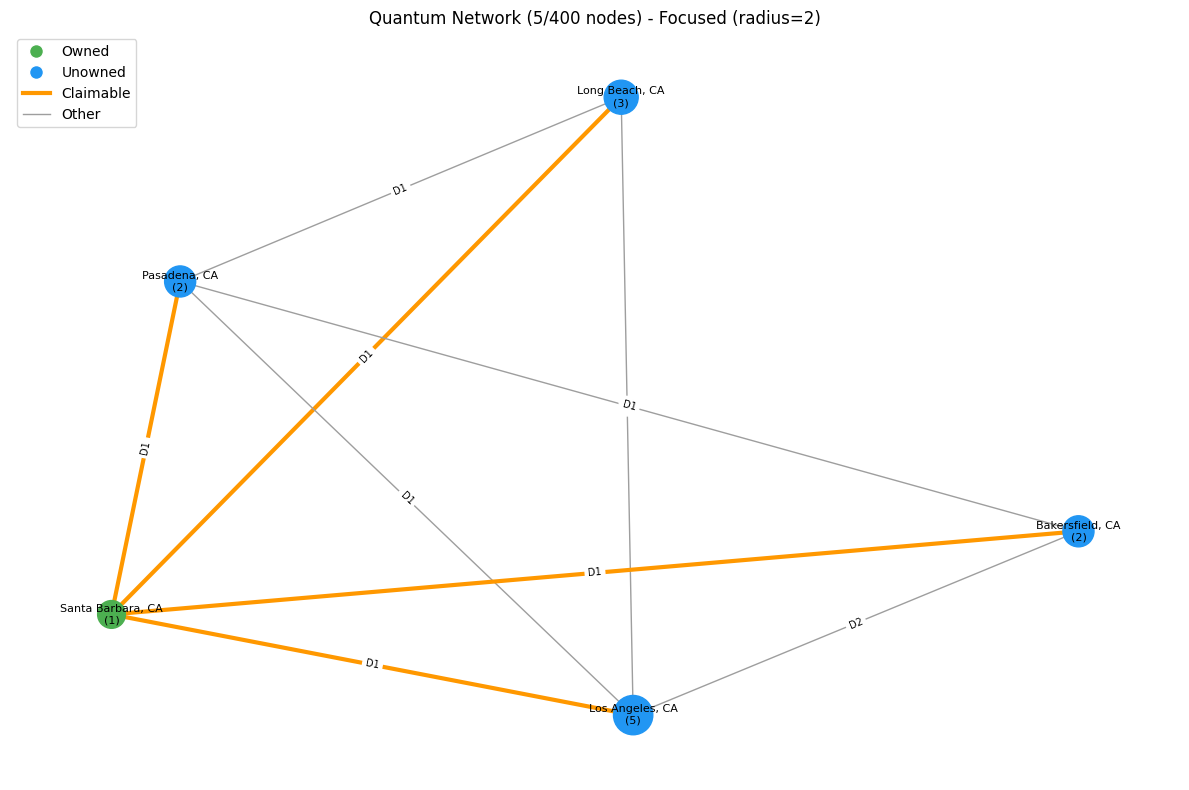

In [9]:
# Visualize the network (focused around your nodes)
viz = GraphTool(client.get_cached_graph())
owned = set(client.get_status().get('owned_nodes', []))
viz.render(owned)

## Step 4: Design a Distillation Circuit

For N Bell pairs, qubits are paired outside-in:
- Pair 0: qubits {0, 2N-1}
- Pair 1: qubits {1, 2N-2}
- ...
- Final pair: qubits {N-1, N}

Design a circuit that improves fidelity through LOCC operations.

In [10]:
!pip install qiskit_qasm3_import

In [24]:
# def create_distillation_circuit():
#     """
#     LOCC-compliant error correction + distillation.

#     Flow:
#     1. Distillation CNOTs
#     2. Measure ancillas
#     3. Apply corrections to DATA qubits based on ancilla measurements
#     4. Done (data qubits q[1], q[2] are the purified output)
#     """

#     qasm_code = """OPENQASM 3.0;
# include "stdgates.inc";
# qubit[4] q;
# bit[2] c;

# // ========================================
# // STAGE 1: Distillation (LOCC-compliant)
# // ========================================
# cx q[1], q[0];  // Alice: data -> ancilla
# cx q[2], q[3];  // Bob: data -> ancilla

# // ========================================
# // STAGE 2: Measure Ancillas
# // ========================================
# measure q[0] -> c[0];  // Alice's ancilla
# measure q[3] -> c[1];  // Bob's ancilla

# // ========================================
# // STAGE 3: Feedforward Corrections
# // (Apply to DATA qubits based on ancilla outcomes)
# // ========================================

# // Case: c[0]=0, c[1]=1 → Apply X on Bob's data
# if (c[1]) {
#     if (!c[0]) {
#         x q[2];
#     }
# }

# // Case: c[0]=1, c[1]=0 → Apply X on Alice's data
# if (c[0]) {
#     if (!c[1]) {
#         x q[1];
#     }
# }

# // Case: c[0]=1, c[1]=1 → Apply Z to flip phase
# if (!c[0]) {
#     if (!c[1]) {
#         z q[1];
#     }
# }


# """

#     from qiskit import qasm3
#     qc = qasm3.loads(qasm_code)
#     return qc

In [47]:
def create_distillation_circuit_robust():
    """
    Multi-layer corrections accounting for all error sources.
    """

    qasm_code = """OPENQASM 3.0;
include "stdgates.inc";
qubit[4] q;
bit[2] c;

// ================================================================
// Layer 1: Symmetrize initial noise
// ================================================================
ry(0.392699) q[1];   // pi/8
ry(0.392699) q[2];
rz(0.196350) q[0];   // pi/16
rz(0.196350) q[3];

// ================================================================
// Layer 2: Distillation
// ================================================================
cx q[1], q[0];
cx q[2], q[3];

// ================================================================
// Layer 3: Measurement
// ================================================================
measure q[0] -> c[0];
measure q[3] -> c[1];

// ================================================================
// Layer 4: Comprehensive corrections
// (Handles initial X, Z, Y errors on BOTH pairs)
// ================================================================

// X corrections (always apply based on measurement)
if (c[0]) x q[1];
if (c[1]) x q[2];

// Z corrections for same-side correlated errors
if (c[0]) {
    if (c[1]) {
        z q[1];
    }
}

// Cross-side Z corrections (initial noise coupling)
if (c[0]) z q[2];  // Alice error → correct Bob
if (c[1]) z q[1];  // Bob error → correct Alice

// Y-error correction (combination of X and Z)
if (c[0]) {
    if (c[1]) {
        z q[2];
        x q[1];
        x q[2];
    }
}
"""

    from qiskit import qasm3
    qc = qasm3.loads(qasm_code)
    return qc

In [12]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, phase_damping_error
import numpy as np

## Step 5: Claim an Edge

In [13]:
# Find claimable edges
claimable = client.get_claimable_edges()
claimable_sorted = sorted(claimable, key=lambda e: (e['difficulty_rating'], e['base_threshold']))

print(f"Claimable edges ({len(claimable)}):")
for edge in claimable_sorted[:5]:
    print(f"  {edge['edge_id']} - threshold: {edge['base_threshold']:.3f}, difficulty: {edge['difficulty_rating']}")

Claimable edges (4):
  ['Bakersfield, CA', 'Santa Barbara, CA'] - threshold: 0.900, difficulty: 1
  ['Los Angeles, CA', 'Santa Barbara, CA'] - threshold: 0.900, difficulty: 1
  ['Pasadena, CA', 'Santa Barbara, CA'] - threshold: 0.900, difficulty: 1
  ['Long Beach, CA', 'Santa Barbara, CA'] - threshold: 0.900, difficulty: 1


In [48]:
# Claim an edge
if claimable:
    target = claimable_sorted[0]  # Easiest edge
    edge_id = tuple(target['edge_id'])

    circuit = create_distillation_circuit()
    num_bell_pairs = 2
    flag_bit = 0  # Classical bit for post-selection (keep when flag=0)

    print(f"Claiming {edge_id} (threshold: {target['base_threshold']:.3f})...")

    result = client.claim_edge(edge_id, circuit, flag_bit, num_bell_pairs)

    if result.get("ok"):
        data = result["data"]
        print(f"Success: {data.get('success')}")
        print(f"Fidelity: {data.get('fidelity', 0):.4f} (threshold: {data.get('threshold', 0):.4f})")
        print(f"Success probability: {data.get('success_probability', 0):.4f}")
    else:
        print(f"Error: {result.get('error', {}).get('message')}")

Claiming ('Bakersfield, CA', 'Santa Barbara, CA') (threshold: 0.900)...
Success: False
Fidelity: 0.8500 (threshold: 0.9000)
Success probability: 0.5000


## Step 6: Check Progress

In [15]:
client.print_status()

Player: asing235 (archana)
Score: 0 | Budget: 76 bell pairs
Active: Yes
Starting node: Santa Barbara, CA
Owned: 1 nodes, 0 edges
Claimable edges: 4
  - ['Bakersfield, CA', 'Santa Barbara, CA']: threshold=0.90, difficulty=1
  - ['Los Angeles, CA', 'Santa Barbara, CA']: threshold=0.90, difficulty=1
  - ['Pasadena, CA', 'Santa Barbara, CA']: threshold=0.90, difficulty=1
  ... and 1 more


In [16]:
# View leaderboard
leaderboard = client.get_leaderboard()["leaderboard"]
print("Leaderboard:")
for i, p in enumerate(leaderboard[:10]):
    print(f"{i+1}. {p.get('player_id', 'Unknown'):20} Score: {p.get('score', 0)}")

Leaderboard:
1. victor_prime         Score: 370
2. tumcuctom            Score: 345
3. riverst03            Score: 321
4. prod_claude          Score: 303
5. ahkatlio_76f0869e    Score: 284
6. winner_team          Score: 263
7. test_claude_1523b    Score: 249
8. evanli_nyu2          Score: 230
9. xstm                 Score: 225
10. Player12345          Score: 208


## Tips

- **Failed attempts are free** - only successful claims cost bell pairs
- **More bell pairs** can improve fidelity but cost more budget
- **Vertex rewards** are competitive - top players by claim strength earn rewards
- **Budget management** is key - if budget reaches 0, you're eliminated

Good luck!

In [17]:
# Restart game (uncomment to use)
# result = client.restart()
# print(result)